### Reading in the data and loading packages

In [9]:
# Import packages
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
from vega_datasets import data

In [2]:
# Read in clean data
df = pd.read_csv("../data/clean_data.csv")
df.head()

,Decision,State,GPA,WorkExp,TestScore,WritingScore,Gender,VolunteerLevel
0,Admit,California,3.90,6.7,962.0,100,1.0,0
1,Admit,Florida,3.80,1.4,969.0,97,1.0,4
2,Admit,Colorado,3.60,0.9,969.0,97,0.0,2
3,Admit,California,3.88,1.5,967.0,95,1.0,5
4,Admit,California,3.70,1.2,969.0,94,1.0,2


### EDA Visuals

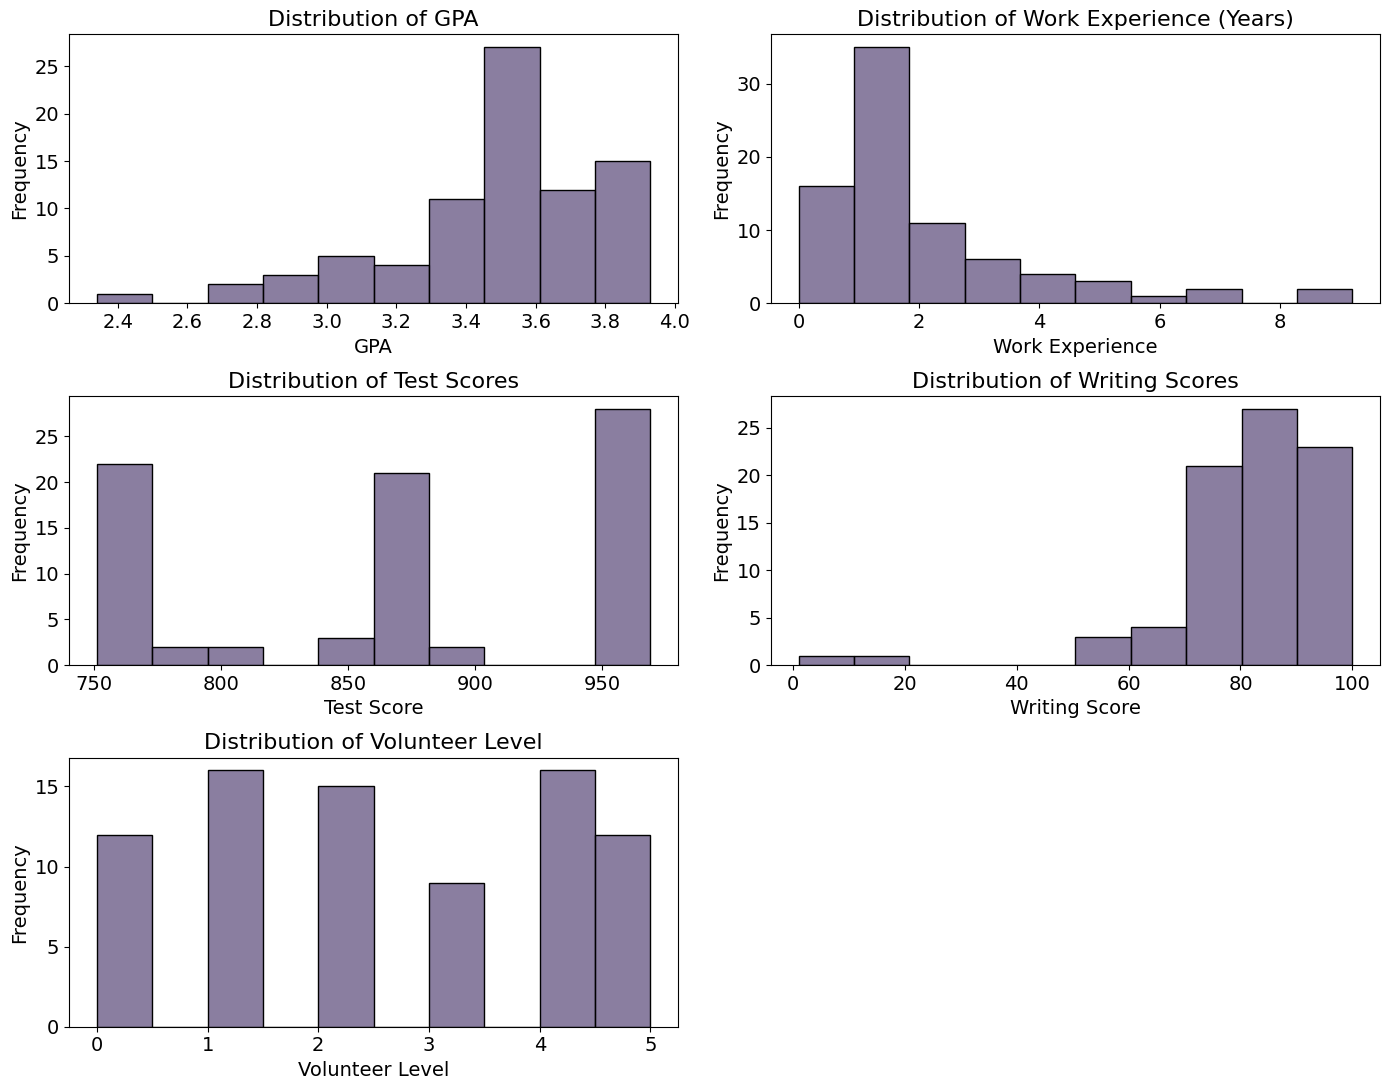

In [11]:
# Histograms of columns to double check for outliers
fig, axes = plt.subplots(3, 2, figsize = (14,11))
sns.histplot(data = df, x = "GPA", bins = 10, kde = False, color = "#635380", edgecolor = "black", ax = axes[0, 0])
axes[0, 0].set_title("Distribution of GPA", fontsize = 16)
axes[0, 0].tick_params(axis = "both", labelsize = 14)
axes[0, 0].set_xlabel("GPA", fontsize = 14)
axes[0, 0].set_ylabel("Frequency", fontsize = 14)

sns.histplot(data = df, x = "WorkExp", bins = 10, kde = False, color = "#635380", edgecolor = "black", ax = axes[0, 1])
axes[0, 1].set_title("Distribution of Work Experience (Years)", fontsize = 16)
axes[0, 1].tick_params(axis = "both", labelsize = 14)
axes[0, 1].set_xlabel("Work Experience", fontsize = 14)
axes[0, 1].set_ylabel("Frequency", fontsize = 14)

sns.histplot(data = df, x = "TestScore", bins = 10, kde = False, color = "#635380", edgecolor = "black", ax = axes[1, 0])
axes[1, 0].set_title("Distribution of Test Scores", fontsize = 16)
axes[1, 0].tick_params(axis = "both", labelsize = 14)
axes[1, 0].set_xlabel("Test Score", fontsize = 14)
axes[1, 0].set_ylabel("Frequency", fontsize = 14)

sns.histplot(data = df, x = "WritingScore", bins = 10, kde = False, color = "#635380", edgecolor = "black", ax = axes[1, 1])
axes[1, 1].set_title("Distribution of Writing Scores", fontsize = 16)
axes[1, 1].tick_params(axis = "both", labelsize = 14)
axes[1, 1].set_xlabel("Writing Score", fontsize = 14)
axes[1, 1].set_ylabel("Frequency", fontsize = 14)

sns.histplot(data = df, x = "VolunteerLevel", bins = 10, kde = False, color = "#635380", edgecolor = "black", ax = axes[2, 0])
axes[2, 0].set_title("Distribution of Volunteer Level", fontsize = 16)
axes[2, 0].tick_params(axis = "both", labelsize = 14)
axes[2, 0].set_xlabel("Volunteer Level", fontsize = 14)
axes[2, 0].set_ylabel("Frequency", fontsize = 14)

fig.delaxes(axes[2, 1])
plt.tight_layout()
plt.show()
fig.savefig("../website/images/variable_histograms.png")

### Investigating gender ratios

/var/folders/_p/d81k_b_93575z7h2220jh4cr0000gn/T/ipykernel_16441/1875275667.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




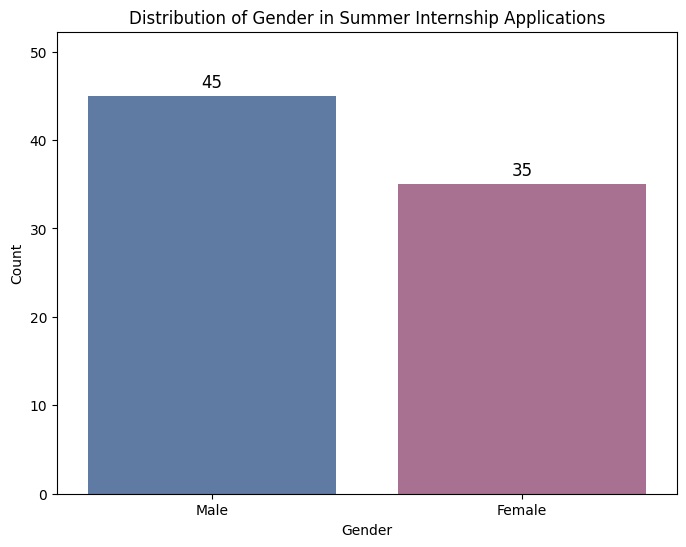

In [14]:
# Bar Chart of Gender Distribution
df["Gender"] = df["Gender"].replace({0: "Female"})
df["Gender"] = df["Gender"].replace({1: "Male"})

fig, ax = plt.subplots(figsize = (8, 6))
ax = sns.countplot(x = "Gender", data = df, palette = ["#5478AE", "#B16792"])

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = "center", va = "center", xytext = (0, 10), textcoords = "offset points", fontsize = 12, color = "black")

ax.set_ylim(0, ax.get_ylim()[1] + 5)

plt.title("Distribution of Gender in Summer Internship Applications")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()
fig.savefig("../website/images/gender_applications_barplot.png")

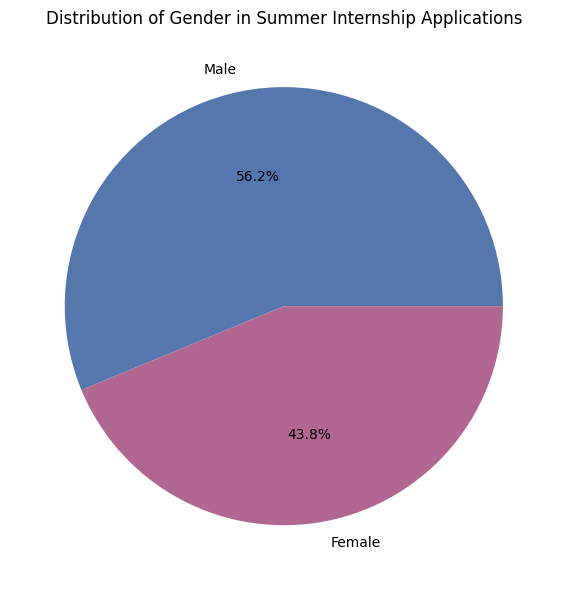

In [16]:
# Pie Chart of Gender Distribution
gender_counts = df['Gender'].value_counts()
gender_counts = pd.DataFrame(gender_counts).reset_index()
gender_counts.columns = ["Gender", "Count"]
gender_counts['Percentage'] = gender_counts['Count'] / gender_counts['Count'].sum()

fig, ax = plt.subplots(figsize = (6, 6))
ax.pie(gender_counts["Percentage"], labels = gender_counts["Gender"], autopct = '%.1f%%', colors = ["#5478AE", "#B16792"])
ax.set_title("Distribution of Gender in Summer Internship Applications")
plt.tight_layout()
plt.show()
fig.savefig("../website/images/gender_applications_piechart.png")

In [7]:
# Source: https://www.geeksforgeeks.org/how-to-create-a-population-pyramid-using-plotly-in-python/
gender_counts_by_state_all = df.groupby("Gender")["State"].value_counts().reset_index()
females_all = gender_counts_by_state_all[gender_counts_by_state_all["Gender"] == "Female"]
males_all = gender_counts_by_state_all[gender_counts_by_state_all["Gender"] == "Male"]
males_all["count"] = males_all["count"]*-1

gender_counts_by_state_admitted = df[df["Decision"] == "Admit"].groupby("Gender")["State"].value_counts().reset_index()
females_admit = gender_counts_by_state_admitted[gender_counts_by_state_admitted["Gender"] == "Female"]
males_admit = gender_counts_by_state_admitted[gender_counts_by_state_admitted["Gender"] == "Male"]
males_admit["count"] = males_admit["count"]*-1

def create_bar_trace(y, x, name, orientation, marker_color):
    trace = go.Bar(y = y, x = x, name = name, orientation = orientation, marker_color = marker_color)
    return trace

def add_data_labels_female(fig, y, x, sep):
    for i, value in enumerate(x):
        fig.add_annotation(dict(x = value+sep, y = y[i], text = str(value), showarrow = False, font = dict(size = 10)))

def add_data_labels_male(fig, y, x, sep):
    for i, value in enumerate(x):
        fig.add_annotation(dict(x = value-sep, y = y[i], text = str(value*-1), showarrow = False, font = dict(size = 10)))

trace1 = create_bar_trace(list(males_all["State"]), males_all["count"], "Male", "h", "#5478AE")
trace2 = create_bar_trace(list(females_all["State"]), females_all["count"], "Female", "h", "#B16792")


fig1 = go.Figure([trace1, trace2])
fig1.update_layout(
    title = "Gender Breakdown by State: ALL Summer Internship Applications",
    title_font_size = 22,
    barmode = "relative",
    bargap = 0.0,
    bargroupgap = 0,
    xaxis = dict(
        tickvals = [-55, -50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55],
        ticktext = ["55", "50", "45", "40", "35", "30", "25", "20", "15", "10", "5", "0", "5", "10", "15", "20", "25", "30", "35", "40", "45", "50", "55"],
        title = "Number of Applications",
        title_font_size = 14))

add_data_labels_male(fig1, list(males_all["State"]), males_all["count"], 0.3)
add_data_labels_female(fig1, list(females_all["State"]), females_all["count"], 0.3)

fig1.show()
fig1.write_image("../website/images/gender_dist_plot_by_state_all.png", engine = "kaleido")

trace3 = create_bar_trace(list(males_admit["State"]), males_admit["count"], "Male", "h", "#5478AE")
trace4 = create_bar_trace(list(females_admit["State"]), females_admit["count"], "Female", "h", "#B16792")

fig2 = go.Figure([trace3, trace4])
fig2.update_layout(
    title = "Gender Breakdown by State: ADMITTED Summer Internship Applications",
    title_font_size=22,
    barmode = "relative",
    bargap = 0.0,
    bargroupgap = 0,
    xaxis = dict(
        tickvals = [-55, -50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55],
        ticktext = ["55", "50", "45", "40", "35", "30", "25", "20", "15", "10", "5", "0", "5", "10", "15", "20", "25", "30", "35", "40", "45", "50", "55"],
        title = "Number of Admitted Interns",
        title_font_size = 14))

add_data_labels_male(fig2, list(males_admit["State"]), males_admit["count"], 0.1)
add_data_labels_female(fig2, list(females_admit["State"]), females_admit["count"], 0.1)

fig2.show()
fig2.write_image("../website/images/gender_dist_plot_by_state_admitted.png", engine = "kaleido")

/var/folders/_p/d81k_b_93575z7h2220jh4cr0000gn/T/ipykernel_16441/36388727.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  males_all["count"] = males_all["count"]*-1
/var/folders/_p/d81k_b_93575z7h2220jh4cr0000gn/T/ipykernel_16441/36388727.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  males_admit["count"] = males_admit["count"]*-1


### ARCHIVE

In [55]:
# Adding per state admission rates
for s in df["State"].unique():
    curr = df[df["State"] == s]
    admit_count = curr[curr["Decision"] == "Admit"].shape[0]
    wait_count = curr[curr["Decision"] == "Waitlist"].shape[0]
    decline_count = curr[curr["Decision"] == "Decline"].shape[0]
    df.loc[df["State"] == s, "AdmitRate"] = (admit_count/curr.shape[0]) * 100
    df.loc[df["State"] == s, "WaitlistRate"] = (wait_count/curr.shape[0]) * 100
    df.loc[df["State"] == s, "DeclineRate"] = (decline_count/curr.shape[0]) * 100
df.head()

,Decision,State,GPA,WorkExp,TestScore,WritingScore,Gender,VolunteerLevel,AdmitRate,WaitlistRate,DeclineRate
0,Admit,California,3.90,6.7,962.0,100,1.0,0,75.000000,16.666667,8.333333
1,Admit,Florida,3.80,1.4,969.0,97,1.0,4,31.428571,31.428571,37.142857
2,Admit,Colorado,3.60,0.9,969.0,97,0.0,2,47.368421,21.052632,31.578947
3,Admit,California,3.88,1.5,967.0,95,1.0,5,75.000000,16.666667,8.333333
4,Admit,California,3.70,1.2,969.0,94,1.0,2,75.000000,16.666667,8.333333


In [69]:
# Get relevant column averages by state
averages_by_state = df.groupby('State')[["AdmitRate", "WaitlistRate", "DeclineRate", "GPA", "TestScore", "WritingScore", "VolunteerLevel"]].mean().reset_index()
state_id_dict = dict(zip(data.population_engineers_hurricanes()["state"], data.population_engineers_hurricanes()["id"]))
# Map state ids
averages_by_state["StateID"] = averages_by_state["State"].map(state_id_dict)
averages_by_state

,State,AdmitRate,WaitlistRate,DeclineRate,GPA,TestScore,WritingScore,VolunteerLevel,StateID
0,Alabama,0.000000,100.000000,0.000000,3.410000,868.000000,85.000000,0.000000,1
1,California,75.000000,16.666667,8.333333,3.600833,916.166667,90.833333,2.666667,6
2,Colorado,47.368421,21.052632,31.578947,3.600526,881.894737,80.684211,2.368421,8
3,Florida,31.428571,31.428571,37.142857,3.559143,872.571429,80.428571,2.457143,12
4,Georgia,0.000000,100.000000,0.000000,3.560000,866.000000,89.000000,1.000000,13
5,Mississippi,0.000000,0.000000,100.000000,2.910000,753.000000,77.000000,1.000000,28
6,New York,0.000000,100.000000,0.000000,3.550000,866.000000,74.000000,1.000000,36
7,Oregon,0.000000,0.000000,100.000000,2.900000,769.000000,87.000000,4.000000,41
8,Utah,16.666667,50.000000,33.333333,3.443333,850.666667,78.333333,2.500000,49
9,Vermont,0.000000,100.000000,0.000000,3.530000,862.000000,85.000000,1.000000,50


In [83]:
states = alt.topo_feature('https://raw.githubusercontent.com/vega/vega-datasets/master/data/us-10m.json', 'states')
click = alt.selection_multi(fields = ["State"])

existing_states = alt.Chart(states).mark_geoshape().encode(
    color = "AdmitRate:Q",
    tooltip = ["State:N", "AdmitRate:Q"],
    opacity = alt.condition('isValid(datum.AdmitRate)', alt.value(1), alt.value(0.2)),
).transform_lookup(
    lookup = "id",
    from_ = alt.LookupData(averages_by_state, "StateID", list(averages_by_state.columns))
).properties(width = 500, height = 300).add_selection(click).project(type = "albersUsa")

missing_states = (
    alt.Chart(states)
    .mark_geoshape(fill = "lightgrey", stroke = "white")
    .encode(opacity=alt.condition("isValid(datum.AdmitRate)", alt.value(0), alt.value(0.2))).add_selection(click).project(type = "albersUsa"))

full_map = existing_states + missing_states

bars = (
    alt.Chart(
        averages_by_state.nlargest(50, "AdmitRate"),
        title = "Top States by Admission Rate").mark_bar().encode(
    x = "AdmitRate",
    opacity = alt.condition(click, alt.value(1), alt.value(0.2)),
    color = "AdmitRate",
    y = alt.Y("State", sort = "x"))
.add_selection(click))

full_map & bars

/Users/miamayerhofer/opt/anaconda3/envs/dsan6600/lib/python3.11/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/Users/miamayerhofer/opt/anaconda3/envs/dsan6600/lib/python3.11/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/Users/miamayerhofer/opt/anaconda3/envs/dsan6600/lib/python3.11/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


alt.VConcatChart(...)